# Determining the cost of cars

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

The customer is important:

- quality predictions;
- prediction speed;
- studying time.

## Data preparation

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [181]:
warnings.filterwarnings('ignore')

In [182]:
df = pd.read_csv('/datasets/autos.csv')

### Data exploration

In [183]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


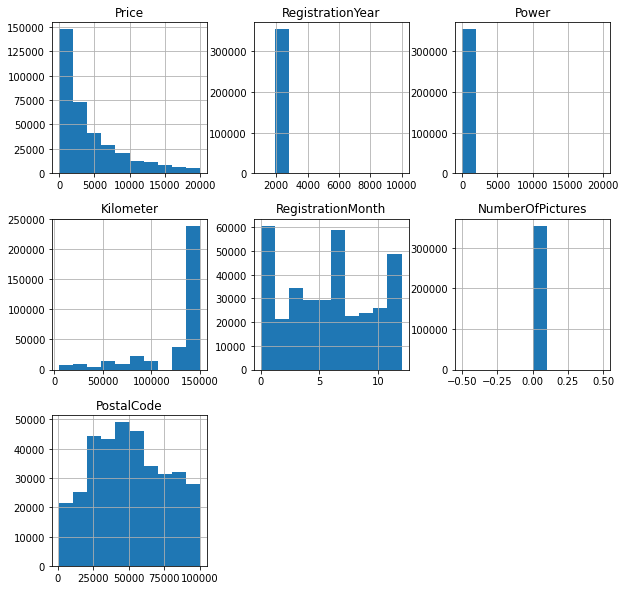

In [184]:
df.hist(figsize=(10,10));

In [185]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Preprocessing

#### Column preprocessing

In [187]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [188]:
df.columns = df.columns.str.lower()

In [189]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [190]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [191]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Now the column names look correct.

#### NaN handling

In [192]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Total lines 354369

Process Nan in:
vehicle_type 37490\
gearbox 19833\
model 19705\
fuel_type 32895\
not_repaired 71154

In [193]:
print('% of NaNs in:')
print('vehicle_type %.2f ' % float(df['vehicle_type'].isna().sum()/354369*100))
print('gearbox %.2f ' % float(df['gearbox'].isna().sum()/354369*100))
print('model %.2f ' % float(df['model'].isna().sum()/354369*100))
print('fuel_type %.2f ' % float(df['fuel_type'].isna().sum()/354369*100))
print('not_repaired %.2f ' % float(df['not_repaired'].isna().sum()/354369*100))

% of NaNs in:
vehicle_type 10.58 
gearbox 5.60 
model 5.56 
fuel_type 9.28 
not_repaired 20.08 


##### vehicle_type

In [194]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [195]:
df[df['vehicle_type']=='other']['vehicle_type'].count()

3288

It is possible to treat NaN as 'other' here, but that doesn't mean we won't introduce noise into this category, where everything will be mixed up.\
Let's create a separate category for NaN: 'is_nan'

In [196]:
df['vehicle_type'] = df['vehicle_type'].fillna('is_nan')

##### gearbox

In [197]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In general, this category cannot be ignored.
nan can be for electric vehicles? - No, they are few.
Let's create a separate category for NaN: 'is_nan'

In [198]:
df['gearbox'] = df['gearbox'].fillna('is_nan')

##### model

In [199]:
df['model'].unique().shape[0]

251

There are a lot of models, this is a very good sign. NaN of only 5% is unlikely to be able to predict the model from the rest of the data.
We will also make the category is_nan

In [200]:
df['model'] = df['model'].fillna('is_nan')

##### fuel_type

In [201]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Any type of fuel can be in NaN, we can predict what type of fuel we can try from the model, but it will not be accurate and very long.\
We can add all NaNs to the `other` category, there are only 204 occurrences, but it’s better to do it normally and create it in the `is_nan`\ category

In [202]:
df['fuel_type'] = df['fuel_type'].fillna('is_nan')

The category `petrol` is the same as `gasoline`:\
Gasoline is the term used in the United States and in North America but petrol is the term used in the United Kingdom and other common wealth countries

In [203]:
df[df['fuel_type'] == 'gasoline']['fuel_type'] = 'petrol'

In [204]:
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
is_nan       32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

##### not_repaired

In [205]:
df['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

I would single out nan in a separate category - is_nan.

In [206]:
df['not_repaired'] = df['not_repaired'].fillna('is_nan')

In [207]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

All NaNs processed

#### Process anomies (outliers)

##### registration_year

<AxesSubplot:>

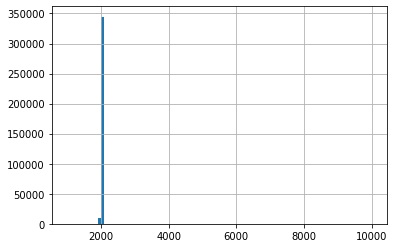

In [208]:
df['registration_year'].hist(bins=100)

<AxesSubplot:>

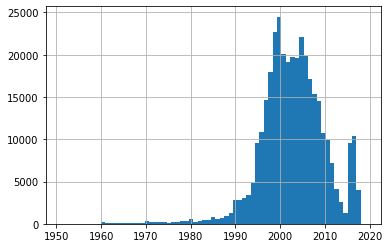

In [209]:
start = 1950
end = 2020
df[(df['registration_year']<end) & (df['registration_year']>start)]['registration_year'].hist(bins=end-start-1)

We can set cars with a registration year > 2016 to nan or remove them because there are not so many such cars. and they look like an outlier.\
In general, DateCrawled cannot be less than registration_year.

In [210]:
print('Доля автомобилей с годом регистрации > 2016:',df[df['registration_year']>2016]['registration_year'].count()/df.shape[0])

Доля автомобилей с годом регистрации > 2016: 0.04100245788993958


There are also not many cars with a year of registration earlier than 1990.

In [211]:
print('Доля автомобилей с годом регистрации < 1990:', df[df['registration_year']<1990]['registration_year'].count()/df.shape[0])

Доля автомобилей с годом регистрации < 1990: 0.027285118054908866


The date of registration cannot be zero, the upper limit is the year the database was collected

<AxesSubplot:>

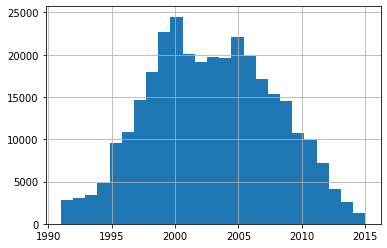

In [212]:
start = 1990
end = 2016
df[(df['registration_year']<end) & (df['registration_year']>start)]['registration_year'].hist(bins=end-start-1)

In [213]:
df = df[(df['registration_year']<end) & (df['registration_year']>start)]

##### price

In [214]:
print('Цена равна 0: ', df[df['price']==0]['price'].count())

Цена равна 0:  8297


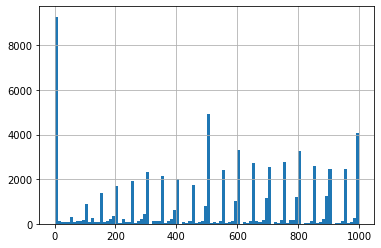

In [215]:
df[df['price']<1000]['price'].hist(bins=100);

In [216]:
df[df['price']<100]['price'].count()/df.shape[0]

0.03258068069170614

In [217]:
df = df[df['price']>=100]

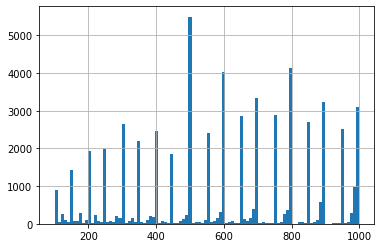

In [218]:
df[df['price']<1000]['price'].hist(bins=100);

##### power

In [219]:
print(df[df['power']==0]['power'].count())

26769


<AxesSubplot:>

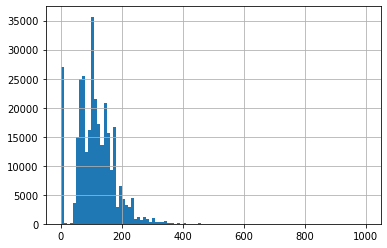

In [220]:
df[df['power']<1000]['power'].hist(bins=100)

Explicit outlier where power is not specified (0) and a long "tail" to the right. We can "cut" it by removing the zeros and taking the upper limit of 1000hp.\
It should be CLEARLY discussed with the customer.

<AxesSubplot:>

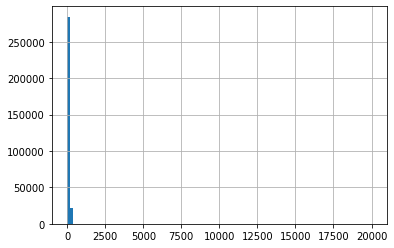

In [222]:
df['power'].hist(bins=100)

In [223]:
df[df['power']==0]['power'].count()

26769

In [224]:
print('Доля автомобилей с мощностью = 0:', df[df['power']==0]['power'].count()/df.shape[0])
print('Доля автомобилей с мощностью > 1000:', df[df['power']>1000]['power'].count()/df.shape[0])

Доля автомобилей с мощностью = 0: 0.08707857858509102
Доля автомобилей с мощностью > 1000: 0.0007774582644789403


Let's make a cycle through the models, inside for each model we will fill in the median if the value is not.

In [226]:
t = df.groupby( ['brand','model'] )['power'].transform( 'median' )
df.loc[df.power.isna() , 'power'] = t 

In [227]:
df['power'].isna().sum()

0

We will remove all cars with a capacity of more than 1000.

In [228]:
df = df.drop(df[df['power']>1000].index, axis=0)
df.reset_index(drop=True,inplace=True)

##### number_of_pictures

In [229]:
print(df[df['number_of_pictures']!=0]['number_of_pictures'].count())

0


there is only `0`\ in `number_of_pictures`
This column can be removed altogether.

Duplicates:

In [230]:
print('Количество дубликатов:',df.duplicated().sum())

Количество дубликатов: 4


In [231]:
df.drop(columns = ['date_crawled','last_seen'], inplace=True)

Non-informative signs:
- number_of_pictures
- postal_code
- date_created
- date_crawled
- last_seen

### Removing duplicates.

In [232]:
print('Доля дубликатов:',df.duplicated().sum()/df.shape[0])

Доля дубликатов: 0.030461661669482668


In [233]:
df.drop_duplicates(inplace=True)

In [234]:
df.drop(columns = ['number_of_pictures', 'postal_code', 'date_created'], inplace=True)

### Conclusion
There were anomalies in the data, about some it would be worth checking with the customer.\
Preprocessing is completed, you can start training the models.

## Model training

### Sample preparation

Encoding categorical features through OHE

In [235]:
df_ohe = pd.get_dummies(df, drop_first=True)

I have finished the features and target.

In [236]:
X = df_ohe.drop(['price'], axis=1)
y = df_ohe['price']

In [237]:
features_train, features_test, target_train, target_test = train_test_split(
    X, y, random_state=12345, test_size=0.25)

Let's do cross-validation:

In [238]:
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

In [239]:
df_ohe.shape

(297816, 310)

In [240]:
enc = OrdinalEncoder()

categories = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

df_ordinal = df.copy()

df_ordinal[categories] = enc.fit_transform(df_ordinal[categories])
X_ordinal = df_ordinal.drop(['price'], axis=1)
y_ordinal = df_ordinal['price']

features_train_o, features_test_o, target_train_o, target_test_o = train_test_split(
    X_ordinal, y_ordinal, random_state=12345, test_size=0.25)

In [241]:
df_ordinal.shape

(297816, 11)

11 columns is obtained

### Model training
#### LightGBM

In [242]:
model_lgbm = LGBMRegressor(random_state=12345)
params = {
    'learning_rate': [0.1, 0.4],
    'n_estimators': [30, 60],
    'num_leaves': [30, 60],
}

gridsearch_lgbm = GridSearchCV(model_lgbm
                          , params
                          , cv=cv
                          , scoring='neg_root_mean_squared_error'
                          , verbose=1)

In [243]:
%%time
gridsearch_lgbm.fit(features_train_o, target_train_o)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 1min 9s, sys: 115 ms, total: 1min 9s
Wall time: 1min 10s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.4], 'n_estimators': [30, 60],
                         'num_leaves': [30, 60]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [244]:
lgbm_train_score = gridsearch_lgbm.best_score_
print('Best score:', gridsearch_lgbm.best_score_)
print('Best params:', gridsearch_lgbm.best_params_)

Best score: -1537.5287776280054
Best params: {'learning_rate': 0.4, 'n_estimators': 60, 'num_leaves': 60}


#### Linear Regression

In [245]:
model_linear = LinearRegression()

In [246]:
%%time
model_linear.fit(features_train, target_train)
scores = cross_val_score(model_linear
                , features_train
                , target_train
                , scoring = 'neg_root_mean_squared_error'
                , cv=cv)

linear_train_score = scores.mean()
print('Best score:', linear_train_score)

Best score: -2254.6174676955566
CPU times: user 40.3 s, sys: 15.7 s, total: 56 s
Wall time: 56.1 s


#### Decision Tree

In [247]:
param = {
    'max_depth': [2,10]
    , 'min_samples_leaf': [30,60]
    , 'min_samples_split': [30, 60]
}

model_tree = DecisionTreeRegressor(random_state=12345)

gridsearch_tree = GridSearchCV(model_tree
                          , param
                          , cv=cv
                          , scoring='neg_root_mean_squared_error'
                          , verbose=1)

In [248]:
%%time
gridsearch_tree.fit(features_train_o, target_train_o)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 5.25 s, sys: 40.9 ms, total: 5.29 s
Wall time: 5.34 s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [2, 10], 'min_samples_leaf': [30, 60],
                         'min_samples_split': [30, 60]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [249]:
tree_train_score = gridsearch_tree.best_score_
print('Best score:', gridsearch_tree.best_score_)
print('Best params:', gridsearch_tree.best_params_)

Best score: -1895.516818987581
Best params: {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 30}


#### Cat boost

Signs for Catboost without OHE.

In [250]:
X_cb = df.drop(['price'], axis=1)
Y_cb = df['price']
features_train_cb, features_test_cb, target_train_cb, target_test_cb = train_test_split(
    X, y, random_state=12345, test_size=0.25)

In [251]:
model_catboost = CatBoostRegressor(random_seed=12345
                          , loss_function='RMSE'
                          , silent=True)

params = {
    'learning_rate': [0.1, 0.4],
    'iterations': [30, 60],
    'depth': [2,6,12],
}

gridsearch_catboost = GridSearchCV(model_catboost,
                        params,
                        cv=cv,
                        scoring='neg_root_mean_squared_error',
                        verbose=False)

In [252]:
%%time
gridsearch_catboost.fit(features_train_cb, target_train_cb);

CPU times: user 1min 46s, sys: 1.2 s, total: 1min 47s
Wall time: 2min 4s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f0cb81f20d0>,
             param_grid={'depth': [2, 6, 12], 'iterations': [30, 60],
                         'learning_rate': [0.1, 0.4]},
             scoring='neg_root_mean_squared_error', verbose=False)

In [253]:
catboost_train_score = gridsearch_catboost.best_score_
print('Best score:', gridsearch_catboost.best_score_)
print('Best params:', gridsearch_catboost.best_params_)

Best score: -1525.4192932499327
Best params: {'depth': 12, 'iterations': 60, 'learning_rate': 0.4}


### Conclusion
Hyperparameters are selected, you can proceed to testing models

## Model Analysis

### Function for testing models

In [254]:
def model_test(model, features_train, target_train, features_test, target_test, train_score):
    t = time.time()
    model.fit(features_train, target_train)
    training_time = time.time() - t
    
    t = time.time()
    prediction = model.predict(features_test)
    prediction_time = time.time() - t
    
    rmse = mean_squared_error(target_test, prediction, squared=False)
    
    return training_time, prediction_time, rmse, train_score

### Testing models

In [255]:
%%time
models_prediction = []
models_prediction.append(model_test(gridsearch_lgbm.best_estimator_,features_train_o, target_train_o, features_test_o, target_test_o, lgbm_train_score))
models_prediction.append(model_test(model_linear,features_train, target_train, features_test, target_test, linear_train_score))
models_prediction.append(model_test(gridsearch_tree.best_estimator_,features_train_o, target_train_o, features_test_o, target_test_o, tree_train_score))
models_prediction.append(model_test(gridsearch_catboost.best_estimator_,features_train_cb, target_train_cb, features_test_cb, target_test_cb, catboost_train_score))


CPU times: user 32.6 s, sys: 8.12 s, total: 40.8 s
Wall time: 41.5 s


In [256]:
models_result_table = pd.DataFrame(data=models_prediction
                                   , index=['LightGBM', 'LinearRegression','DecisionTreeRegressor' ,'CatBoost']
                                   , columns=['trainig_time', 'predict_time', 'RMSE', 'RMSE train (CV)'])

### Test result

In [257]:
models_result_table

,trainig_time,predict_time,RMSE,RMSE train (CV)
LightGBM,9.881733,0.306585,1513.538678,-1537.528778
LinearRegression,22.390569,0.309243,2244.300755,-2254.617468
DecisionTreeRegressor,0.616900,0.009768,1856.032643,-1895.516819
CatBoost,7.952251,0.061913,1500.272868,-1525.419293


### Conclusion
According to the table, we see that the prediction is best for the CatBoost model, and also faster.\
And the decision tree, although worse, works much faster.

## Checklist

Put 'x' in completed items. Then press Shift+Enter.

- [x] Jupyter Notebook open
- [x] All code runs without errors
- [x] Cells with code are arranged in execution order
- [x] Data loaded and prepared
- [x] Models trained
- [x] There is an analysis of the speed and quality of models